In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.data_tools.plotting_utils import *
from f1tenth_benchmarks.data_tools.process_data import process_data

if os.getcwd().split('/')[-1] == 'benchmark_results':
    os.chdir('..')
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
process_data()

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim
Complied Full.csv and Summary.csv.


# Load Data

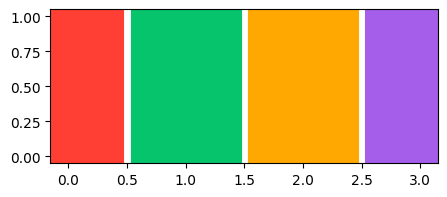

In [3]:
# planners = ['FullStackPP', "FullStackMPCC", "FollowTheGap", "EndToEnd"]
# test_ids = ["ts_t1", "mpcc_t1", "Std", "TD3_TAL_12_gbr"]

planners = ['GlobalPlanPP', "GlobalPlanMPCC", "FollowTheGap", "EndToEnd"]
test_ids = ["mu90_steps2", "fs_mpcc_mu90", "Std", "TD3_TAL_13_mco"]
neat_planner_names = ["Opti. & tracking", "MPCC", "Follow-the-gap", "End-to-end"]
n_planners = len(planners)
map_list = ["aut", "esp", "gbr", "mco"]

planner_colors = [red_orange, sweedish_green, chrome_yellow, lighter_purple]
plt.figure(figsize=(5, 2))
for i in range(n_planners):
    plt.plot([i, i], [0, 1], color=planner_colors[i], linewidth=80)
    

In [4]:
summary_df = pd.read_csv("Logs/Summary.csv")
results_df = summary_df.loc[summary_df.Vehicle.isin(planners)]
results_df = results_df.loc[results_df.TestID.isin(test_ids)]

times_df = results_df[['Vehicle', 'MapName', 'AvgTime']]
times_df = times_df.pivot(index="Vehicle", columns="MapName", values="AvgTime")
times_df.columns = times_df.columns.str.upper()
times_df.rename(index=dict(zip(planners, neat_planner_names)), inplace=True)
times_df.sort_values(by="Vehicle", inplace=True, ascending=False)
print(times_df)

times_df.to_latex(f"{save_path}benchmark_laptimes.tex", float_format="%.2f")

MapName               AUT      ESP      GBR     MCO
Vehicle                                            
Opti. & tracking  16.8140  36.0567  31.3980  28.744
MPCC              16.9720  39.1657  35.5086  31.640
Follow-the-gap    19.0844  45.7680  39.3320  35.008
End-to-end        19.0160  43.7840  38.1120  33.816


/tmp/ipykernel_541001/1996046663.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


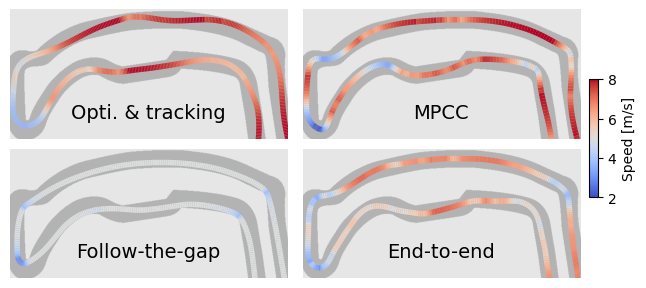

In [9]:
plot_map = "mco"
lap_n = 4

map_data = MapData(plot_map)
lap_dfs = []

for i, planner_name in enumerate(planners):
    data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["planner"] = planner_name

    lap_dfs.append(df)
lap_df = pd.concat(lap_dfs)

fig, axs = plt.subplots(2, 2, figsize=(6., 3), sharex=True, sharey=True)
axs_list = axs.flatten()
for i in range(n_planners):
    plt.sca(axs_list[i])
    map_data.plot_map_img()

    df = lap_df[lap_df["planner"] == planners[i]]
    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(2, 8)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(4)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs_list[i].set_aspect('equal')
    plt.xlim(60, 650)
    plt.ylim(725, 1000)
    plt.text(0.5, 0.2, neat_planner_names[i], horizontalalignment='center', verticalalignment='center', transform=axs_list[i].transAxes, size=14)

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.09, ax.get_position().y0+0.2, 0.015, ax.get_position().height*1.2])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])

plt.tight_layout()
plt.savefig(f"{save_path}speed_trajectories_{plot_map}.pdf", bbox_inches='tight')

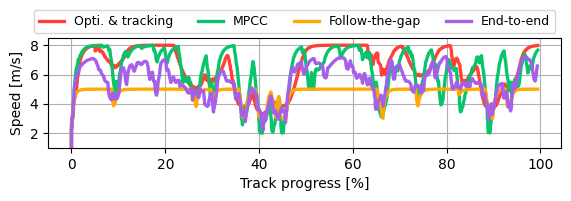

In [10]:
map_name = "aut"
lap_n = 0
lap_dfs = []
for i, planner_name in enumerate(planners):
    data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["planner"] = planner_name
    lap_dfs.append(df)


lap_df = pd.concat(lap_dfs)
fig, ax1 = plt.subplots(1, 1, figsize=(6., 2.2), sharex=True)
map_data = MapData(plot_map)

for i in range(4):
    df = lap_df[lap_df["planner"] == planners[i]]
    ax1.plot(df["progress"]*100, df["speed"], label=neat_planner_names[i], alpha=0.99, color=planner_colors[i], linewidth=2.4)

ax1.grid(True)
ax1.set_ylim(1., 8.5)
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

plt.legend(ncol=4, loc="center", bbox_to_anchor=(0.48, 1.15), fontsize=9)
plt.xlabel("Track progress [%]")
plt.ylabel("Speed [m/s]")

plt.tight_layout()
plt.savefig(f"{save_path}speed_comparison_{map_name}.pdf", bbox_inches='tight', pad_inches=0.0)
plt.savefig(f"{save_path}speed_comparison_{map_name}.svg", bbox_inches='tight', pad_inches=0.0)

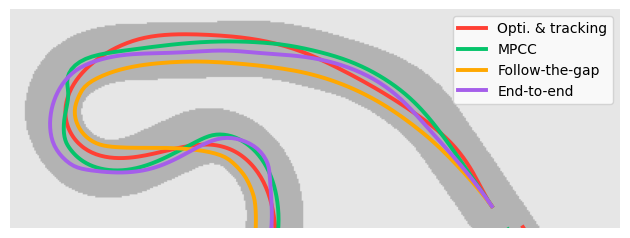

In [14]:
plot_map = "gbr"
lap_n = 2
lap_dfs = []
for i, planner_name in enumerate(planners):
    data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["planner"] = planner_name

    lap_dfs.append(df)
lap_df = pd.concat(lap_dfs)

map_data = MapData(plot_map)
map_data.plot_map_img()
for i in range(n_planners):
    df = lap_df[lap_df["planner"] == planners[i]]

    xs, ys = map_data.xy2rc(df.x, df.y)
    plt.plot(xs, ys, linewidth=2.8, color=planner_colors[i], label=neat_planner_names[i])
    
plt.axis('off')
plt.legend()
plt.xlim(840, 1230)
plt.ylim(720, 860)

plt.tight_layout()
plt.savefig(f"{save_path}path_comparison_{plot_map}.svg", bbox_inches='tight', pad_inches=0)
plt.savefig(f"{save_path}path_comparison_{plot_map}.pdf", bbox_inches='tight', pad_inches=0)
